# 비디오와 정량 지표 변화 같이 나타내기

In [10]:
import cv2
import yt_dlp

def openVideoStream(youtube_url: str) -> cv2.VideoCapture:
    """
    OpenCV를 사용하여 YouTube progressive 스트림 중 720p + 30fps를 우선 선택하고,
    720p가 없을 경우 progressive 중 최대 해상도 스트림을 fallback으로 선택합니다.
    """
    print(f"'{youtube_url}'에서 progressive 720p 스트림 URL을 가져오는 중...")

    ydl_options = {
        "format": "bestvideo+bestaudio/best",
        "noplaylist": True,
        "quiet": True,
        "no_warnings": True,
        "cookiefile": "./cooks.txt",  # 필요 없다면 생략 가능
    }

    with yt_dlp.YoutubeDL(ydl_options) as ydl:
        info_dict = ydl.extract_info(youtube_url, download=False)
        formats = info_dict.get("formats", [])

        # ✅ 1차 시도: progressive + 30fps + height == 720
        selected_format = None
        for f in formats:
            if (
                f.get("vcodec") != "none"
                and f.get("acodec") != "none"
                and f.get("url")
                and f.get("height") == 720
                and f.get("fps") == 30
            ):
                selected_format = f
                break

        # 🔁 2차 시도: progressive 중 최대 해상도
        if not selected_format:
            print("⚠️ 720p @30fps progressive 스트림 없음 → fallback으로 최대 해상도 progressive 선택")
            max_height = -1
            for f in formats:
                if (
                    f.get("vcodec") != "none"
                    and f.get("acodec") != "none"
                    and f.get("url")
                    and f.get("height", 0) > max_height
                ):
                    selected_format = f
                    max_height = f["height"]

        if not selected_format:
            print("❌ progressive 스트림을 찾을 수 없습니다.")
            return False

        video_stream_url = selected_format["url"]
        print(
            f"🎬 선택된 스트림: {selected_format['ext']} | "
            f"{selected_format['height']}p @ {selected_format.get('fps', 'N/A')}fps"
        )
        print(f"URL: {video_stream_url}")
        cap = cv2.VideoCapture(video_stream_url)
        if not cap.isOpened():
            print("❌ OpenCV로 스트림을 열 수 없습니다.")
            return False

        return cap


In [11]:
import numpy as np
import cv2, os, time
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from tqdm import tqdm
import utils  # utils 모듈 임포트
import matplotlib

def extractFrames(
    cap,
    start_time_sec,
    duration_sec,
    fps,
    output_folder_path,
    resize_to=(320, 180),  # 원하는 해상도 (width, height)
):
    """
    grab + retrieve + resize 최적화된 프레임 추출
    """

    if not cap.isOpened():
        print("❌ VideoCapture 열기 실패")
        return False

    os.makedirs(output_folder_path, exist_ok=True)

    # 영상 정보
    video_fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    total_duration_sec = total_frames / video_fps

    # 시작/종료 프레임 계산
    start_frame = int(start_time_sec * video_fps)
    if duration_sec is None:
        end_frame = total_frames
        print(f"📌 duration_sec=None → 끝까지 추출 (총 {total_duration_sec:.2f}s)")
    else:
        end_frame = int((start_time_sec + duration_sec) * video_fps)

    frame_interval = max(1, int(round(video_fps / fps)))

    print(f"\n🎬 시작 프레임: {start_frame}, 종료 프레임: {end_frame}")
    print(f"🎯 프레임 간격: {frame_interval} (video fps: {video_fps:.2f})")
    print(f"🖼️ 해상도 축소: {resize_to[0]}x{resize_to[1]}")

    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    extraction_start_time = time.time()
    current_frame = start_frame
    saved_count = 0

    while current_frame < end_frame:
        grabbed = cap.grab()
        if not grabbed:
            print("❌ grab 실패 또는 영상 끝 도달")
            break

        if (current_frame - start_frame) % frame_interval == 0:
            ret, frame = cap.retrieve()
            if not ret or frame is None:
                print("❌ retrieve 실패")
                break

            # 해상도 줄이기
            frame = cv2.resize(frame, resize_to, interpolation=cv2.INTER_AREA)

            filename = os.path.join(
                output_folder_path,
                (
                    f"{start_time_sec}s_{fps}fps_{saved_count:03d}.jpg"
                    if duration_sec is None
                    else f"{start_time_sec}s_{duration_sec}s_{fps}fps_{saved_count:03d}.jpg"
                ),
            )
            cv2.imwrite(filename, frame, [cv2.IMWRITE_JPEG_QUALITY, 95])
            saved_count += 1

        current_frame += 1

    extraction_end_time = time.time()
    print(
        f"✅ 총 {saved_count}개 프레임 저장 완료. 소요 시간: {extraction_end_time - extraction_start_time:.2f}초"
    )
    return saved_count


In [12]:
url = 'https://www.youtube.com/watch?v=h4ILpWwU1LM'
import utils, cv2
cap = openVideoStream(url)
# utils.extractFrames(cap, 0, None, cap.get(cv2.CAP_PROP_FPS), './sing')
extractFrames(cap, 0, None, cap.get(cv2.CAP_PROP_FPS), './sing')

'https://www.youtube.com/watch?v=h4ILpWwU1LM'에서 progressive 720p 스트림 URL을 가져오는 중...
⚠️ 720p @30fps progressive 스트림 없음 → fallback으로 최대 해상도 progressive 선택
🎬 선택된 스트림: mp4 | 296p @ 30fps
URL: https://rr2---sn-n3cgv5qc5oq-bh2sy.googlevideo.com/videoplayback?expire=1752756337&ei=EZx4aN_mOfvR29gPn-CKgAg&ip=163.180.118.139&id=o-ANogIfC9Q_usSD3ssaNKTfoa2Jv0imSNzWB_o7A4SqQy&itag=18&source=youtube&requiressl=yes&xpc=EgVo2aDSNQ%3D%3D&met=1752734737%2C&mh=J2&mm=31%2C26&mn=sn-n3cgv5qc5oq-bh2sy%2Csn-oguesnd6&ms=au%2Conr&mv=m&mvi=2&pl=19&rms=au%2Cau&gcr=kr&initcwndbps=4585000&bui=AY1jyLOeEDlT8XOy__CEwcRXwrMbt9RHEMTDtxNpYO_4Wo9JifdpUdJbAxjHkKlvUodl3k8MOfBVAZhl&vprv=1&svpuc=1&mime=video%2Fmp4&ns=0rLnKMjADsICgnqiI8NwWNkQ&rqh=1&cnr=14&ratebypass=yes&dur=299.630&lmt=1697073528596169&mt=1752734256&fvip=2&lmw=1&fexp=51544120&c=TVHTML5&sefc=1&txp=5438434&n=AS2Y2vTcXkNgiw&sparams=expire%2Cei%2Cip%2Cid%2Citag%2Csource%2Crequiressl%2Cxpc%2Cgcr%2Cbui%2Cvprv%2Csvpuc%2Cmime%2Cns%2Crqh%2Ccnr%2Cratebypass%2Cdur%2Clmt

8987

시각
- TI(Optical Flow)
- SI

청각
- 음 종류
- 스피치
    - 조음속도
- 음악
    - 템포
    - 볼륨
    - 에너지

In [13]:
def play_video_with_metrics(cap, si, ti, optic_flow, output_path, window_size=5):
    import numpy as np
    import cv2
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    import matplotlib.animation as animation
    from IPython.display import HTML
    import matplotlib as mpl
    from tqdm import tqdm

    mpl.rcParams['animation.embed_limit'] = 50_000_000

    # --- Step 1. 영상 프레임 로딩 ---
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
    cap.release()

    # --- Step 2. 시각화용 시간 축 ---
    x_time = np.arange(total_frame) / fps
    x_time_ti = x_time[:-1]  # TI, OF는 길이 1 작음
    duration = x_time[-1]

    # --- Step 3. 그리드 레이아웃 설정 ---
    fig = plt.figure(figsize=(10, 6))
    gs = gridspec.GridSpec(3, 2, width_ratios=[2, 3])

    # 왼쪽 영상
    ax_video = fig.add_subplot(gs[:, 0])
    img_disp = ax_video.imshow(frames[0])
    ax_video.axis('off')
    ax_video.set_title("Video")

    # 오른쪽 그래프 3개
    ax_si = fig.add_subplot(gs[0, 1])
    ax_ti = fig.add_subplot(gs[1, 1])
    ax_of = fig.add_subplot(gs[2, 1])

    # SI
    ax_si.plot(x_time, si, color='blue', label='SI')
    cursor_si = ax_si.axvline(x=0, color='r', linestyle='--')
    ax_si.set_xlim(0, window_size)
    ax_si.set_ylim(np.min(si) - 5, np.max(si) + 5)
    ax_si.set_ylabel("SI")
    ax_si.grid(True)

    # TI
    ax_ti.plot(x_time_ti, ti, color='green', label='TI')
    cursor_ti = ax_ti.axvline(x=0, color='r', linestyle='--')
    ax_ti.set_xlim(0, window_size)
    ax_ti.set_ylim(np.min(ti) - 5, np.max(ti) + 5)
    ax_ti.set_ylabel("TI")
    ax_ti.grid(True)

    # Optical Flow
    ax_of.plot(x_time_ti, optic_flow, color='orange', label='Optical Flow')
    cursor_of = ax_of.axvline(x=0, color='r', linestyle='--')
    ax_of.set_xlim(0, window_size)
    ax_of.set_ylim(np.min(optic_flow) - 5, np.max(optic_flow) + 5)
    ax_of.set_xlabel("Time (s)")
    ax_of.set_ylabel("Optical Flow")
    ax_of.grid(True)

    # --- Step 4. 업데이트 함수 ---
    def update(frame_idx):
        current_time = frame_idx / fps
        img_disp.set_data(frames[frame_idx])

        # 모든 세로선 위치 업데이트
        for cursor in [cursor_si, cursor_ti, cursor_of]:
            cursor.set_xdata([current_time, current_time])

        # 슬라이딩 x축
        if current_time > window_size / 2:
            left = current_time - window_size / 2
            right = current_time + window_size / 2
            if right > duration:
                right = duration
                left = duration - window_size
        else:
            left, right = 0, window_size

        for ax in [ax_si, ax_ti, ax_of]:
            ax.set_xlim(left, right)

        return img_disp, cursor_si, cursor_ti, cursor_of

    # --- Step 5. 애니메이션 실행 ---
    ani = animation.FuncAnimation(
        fig, update,
        frames=len(frames),
        interval=1000/fps,
        blit=False
    )

    with tqdm(total=len(frames), desc="Rendering frames") as pbar:
        def _progress(i, n):
            pbar.update(i - pbar.n)

        ani.save(f"{output_path}.mp4", fps=fps, dpi=150, progress_callback=_progress)

Calculating Optical Flow: 100%|██████████| 8987/8987 [00:12<00:00, 701.27it/s]


[Optical Flow] 보간된 프레임 수: 39개
[Optical Flow] 보간된 프레임 인덱스: [1227, 1228, 1283, 1305, 1726, 1862, 2032, 2805, 3007, 3099, 3861, 3863, 3876, 3994, 4129, 4261, 4311, 4642, 5040, 5041, 5163, 5667, 6091, 6132, 6274, 6463, 6464, 6465, 6468, 6470, 6474, 7420, 7584, 7857, 7884, 7885, 7913, 8252, 8838]


Calculating TI: 100%|██████████| 8987/8987 [00:05<00:00, 1670.07it/s]


'https://www.youtube.com/watch?v=h4ILpWwU1LM'에서 progressive 720p 스트림 URL을 가져오는 중...
⚠️ 720p @30fps progressive 스트림 없음 → fallback으로 최대 해상도 progressive 선택
🎬 선택된 스트림: mp4 | 296p @ 30fps
URL: https://rr2---sn-n3cgv5qc5oq-bh2sy.googlevideo.com/videoplayback?expire=1752756540&ei=3Jx4aLeNGLni29gPttWowQ0&ip=163.180.118.139&id=o-ANlbRJH3BOXW1eA1grGscnMCT7fsc1Mbznl9oYIhi3GU&itag=18&source=youtube&requiressl=yes&xpc=EgVo2aDSNQ%3D%3D&met=1752734940%2C&mh=J2&mm=31%2C26&mn=sn-n3cgv5qc5oq-bh2sy%2Csn-oguesnd6&ms=au%2Conr&mv=m&mvi=2&pl=19&rms=au%2Cau&gcr=kr&initcwndbps=4868750&bui=AY1jyLMBrunrulvpDehHk7pWNcmBJxQC3hzxcH1i2KtCWSknon_DBSeRouVOGM5d1zBYGBgjxsCR9BIi&vprv=1&svpuc=1&mime=video%2Fmp4&ns=ppvEGCErnLde-pO5MwcpldgQ&rqh=1&cnr=14&ratebypass=yes&dur=299.630&lmt=1697073528596169&mt=1752734487&fvip=2&lmw=1&fexp=51544120&c=TVHTML5&sefc=1&txp=5438434&n=VDtlVC-2VOa3eg&sparams=expire%2Cei%2Cip%2Cid%2Citag%2Csource%2Crequiressl%2Cxpc%2Cgcr%2Cbui%2Cvprv%2Csvpuc%2Cmime%2Cns%2Crqh%2Ccnr%2Cratebypass%2Cdur%2Clmt

Rendering frames: 100%|█████████▉| 8986/8987 [16:31<00:00,  9.07it/s]


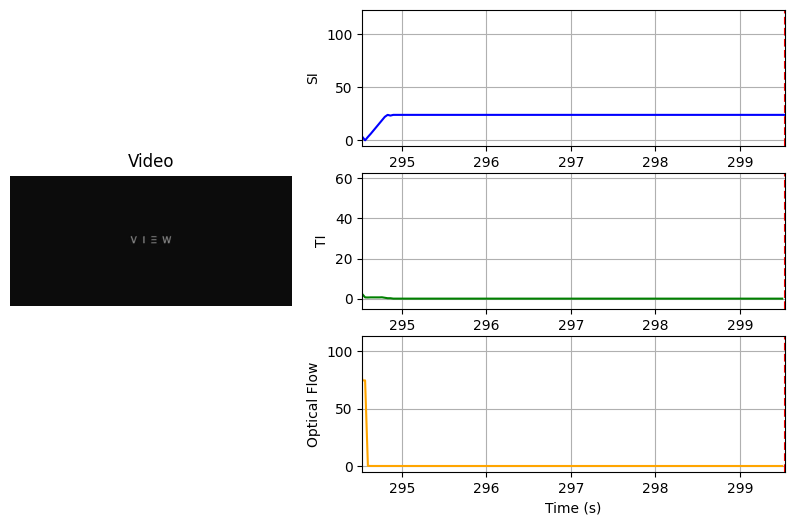

In [16]:
import utils
si = utils.calculateSI('./sing')
optic_flow = utils.calculateOpticalFlow('./sing')
ti = utils.calculateTI('./sing')

url = 'https://www.youtube.com/watch?v=h4ILpWwU1LM'
import utils, cv2
cap = openVideoStream(url)
play_video_with_metrics(cap, si, ti, optic_flow, 'sing')

문제: TI 값 계산이 제대로 안되는 듯